In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, kstest, norm
import seaborn as sns

# Functions developed for the project
from src.statistics import (
    levene_analysis,
    mannwhitneyu_analysis,
    ttest_ind_analysis,
    remove_outliers,
)
from src.config import PROCESSED_DATA

In [2]:
df_diabetes_processed = pd.read_parquet(PROCESSED_DATA)

numerical_columns = df_diabetes_processed.select_dtypes(include="number").columns.tolist()
target_column = "Diabetes"

In [3]:
df_diabetes_wo_outliers = df_diabetes_processed.copy()

for column in numerical_columns:
    df_diabetes_wo_outliers[column] = remove_outliers(df_diabetes_wo_outliers[column])

df_diabetes_wo_outliers.describe()

,BMI,DaysMentalHealth,DaysPhysicalHealth
count,68511.000000,58876.000000,60068.000000
mean,29.129673,0.526615,1.880619
std,5.695466,1.271375,3.727202
min,13.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000
75%,33.000000,0.000000,2.000000
max,45.000000,5.000000,15.000000


In [4]:
df_diabetes_wo_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Diabetes              70692 non-null  category
 1   HighBP                70692 non-null  category
 2   HighChol              70692 non-null  category
 3   CholCheck             70692 non-null  category
 4   BMI                   68511 non-null  float64 
 5   Smoker                70692 non-null  category
 6   Stroke                70692 non-null  category
 7   HeartDiseaseorAttack  70692 non-null  category
 8   PhysActivity          70692 non-null  category
 9   Fruits                70692 non-null  category
 10  Veggies               70692 non-null  category
 11  HvyAlcoholConsump     70692 non-null  category
 12  AnyHealthcare         70692 non-null  category
 13  NoDocbcCost           70692 non-null  category
 14  GeneralHealth         70692 non-null  category
 15  Da

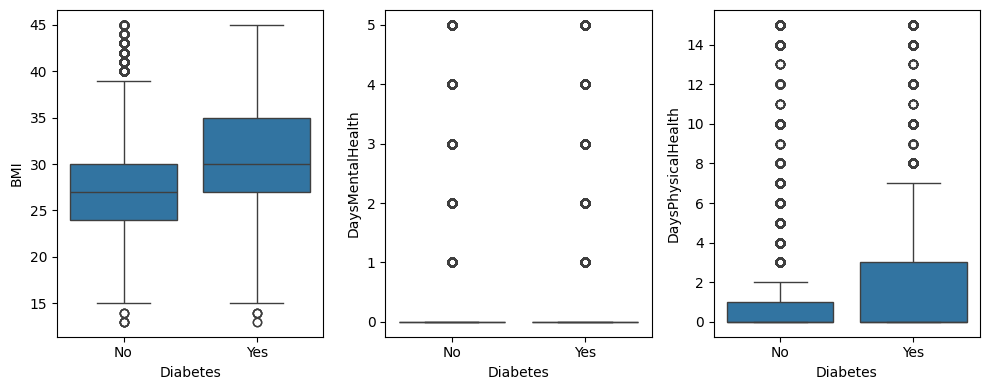

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, column in zip(axs, numerical_columns):
    sns.boxplot(data=df_diabetes_wo_outliers, x=target_column, y=column, ax=ax)

plt.tight_layout()
plt.show()

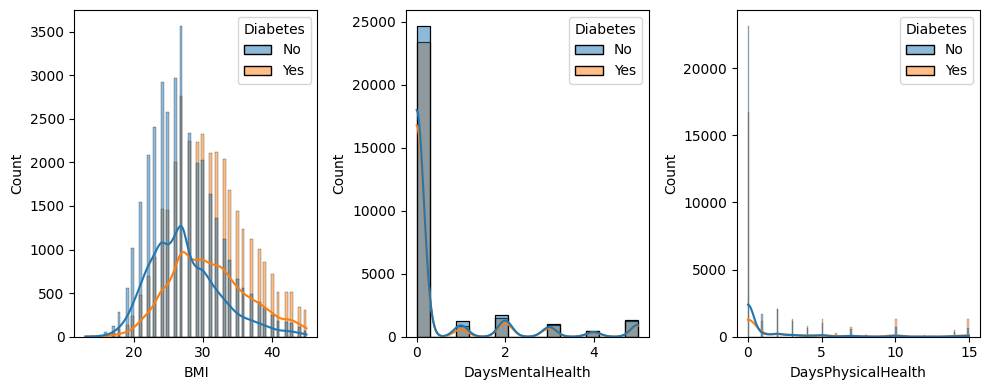

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, column in zip(axs, numerical_columns):
    sns.histplot(data=df_diabetes_wo_outliers, x=column, hue=target_column, kde=True, ax=ax)

plt.tight_layout()
plt.show()

In [7]:
df_diabetes_wo_outliers.groupby(target_column, observed=False).skew(numeric_only=True)

,BMI,DaysMentalHealth,DaysPhysicalHealth
Diabetes,,,
No,0.714415,2.454599,2.874805
Yes,0.323244,2.507093,1.856026


In [8]:
df_diabetes_wo_outliers.groupby(target_column, observed=False)[numerical_columns].apply(pd.DataFrame.kurtosis)

,BMI,DaysMentalHealth,DaysPhysicalHealth
Diabetes,,,
No,0.481335,5.003764,8.079214
Yes,-0.343434,5.185706,2.367289


In [9]:
data_bmi_yes_wo_outliers = df_diabetes_wo_outliers.query("Diabetes == 'Yes'")["BMI"].values
data_bmi_no_wo_outliers = df_diabetes_wo_outliers.query("Diabetes == 'No'")["BMI"].values

df_bmi_wo_outliers = pd.DataFrame({"Yes": data_bmi_yes_wo_outliers, "No": data_bmi_no_wo_outliers})
df_bmi_wo_outliers

,Yes,No
0,30.0,26.0
1,25.0,26.0
2,28.0,26.0
3,23.0,28.0
4,27.0,29.0
...,...,...
35341,37.0,23.0
35342,29.0,29.0
35343,25.0,24.0
35344,18.0,NaN


In [14]:
df_bmi_wo_outliers['Yes'].mean()

30.927493165339357

In [11]:
df_bmi_wo_outliers["No"].mean()

27.39410195358444

In [15]:
print(
    kstest(
        df_bmi_wo_outliers["No"], 
        norm.cdf, 
        args=(df_bmi_wo_outliers["No"].mean(), 
              df_bmi_wo_outliers["No"].std()), 
        nan_policy="omit")
)

print(
    kstest(
        df_bmi_wo_outliers["Yes"], 
        norm.cdf, 
        args=(df_bmi_wo_outliers["Yes"].mean(), 
              df_bmi_wo_outliers["Yes"].std()), 
        nan_policy="omit")
)

KstestResult(statistic=0.10815079726309113, pvalue=0.0, statistic_location=27.0, statistic_sign=1)
KstestResult(statistic=0.07345716240963451, pvalue=2.3370072025211114e-158, statistic_location=30.0, statistic_sign=1)


In [16]:
levene_analysis(df_bmi_wo_outliers, center="median")

Levene's Test
statistics_levene=532.986
At least one variance is different (p-value: 0.000)


In [17]:
ttest_ind_analysis(df_bmi_wo_outliers, equal_variances=False)

Student's t-test
statistics_ttest=85.248
Rejects the null hypothesis (p-value: 0.000)


In [18]:
mannwhitneyu_analysis(df_bmi_wo_outliers)

Mann-Whitney's Test
statistics_mw=801702843.000
Rejects the null hypothesis (p-value: 0.000)


Links e artigos sobre testes de hipótese em datasets grandes:

- https://stats.stackexchange.com/questions/2492/is-normality-testing-essentially-useless
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/pdf/ijem-10-486.pdf
- https://www.bmj.com/content/bmj/310/6975/298.full.pdf
- https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/1471-2288-12-81